#  set autocomplete

In [1]:
%config IPCompleter.greedy=True

# Eager Mode Mnist

In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()
import numpy as np

mnist image : 28,28 

In [3]:
mnist = tf.keras.datasets.mnist

# Create Model

In [4]:
from tensorflow.keras import layers

class Mnist(tf.keras.Sequential):
    def __init__(self):
        super(Mnist, self).__init__()
        self.conv1 = layers.Conv2D(16,[3,3], activation='relu')
        self.conv2 = layers.Conv2D(16,[3,3], activation='relu')
        self.conv3 = layers.Conv2D(16,[3,3], activation='relu')
        self.flat = layers.Flatten()
        self.dense = layers.Dense(10)
    
    def __call__(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense(x)
        return x

In [5]:
model = Mnist()
print(model)
x = tf.random_normal([1,28,28,1])
print(model(x).shape)

(1, 10)


# Load Data 

In [6]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [7]:
for images, labels in dataset.take(1):
    print(images[0:1].shape)
    print("Logis", model(images[0:1]).shape)

(1, 28, 28, 1)
Logis (1, 10)


# Define Optimizer

In [8]:
optimizer = tf.train.AdamOptimizer()

# Train

In [9]:
device = '/cpu:0' if tfe.num_gpus() == 0 else '/gpu:0'
print('using device %s' %device)
epoch=2
loss_history = []
acc_history = []

with tf.device(device):  
    for _ in range(epoch):
        for ( batch, (images, labels)) in enumerate(dataset.take(6000)):
            accuracy = tfe.metrics.Accuracy('accuracy', dtype=tf.float32)
            with tf.GradientTape() as tape:
                logits = model(images)
                loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)
                accuracy(tf.argmax(logits, axis=1, output_type=tf.int64),
                        tf.cast(labels, tf.int64))

            loss_history.append(loss_value.numpy())
            acc_history.append(accuracy.result())
            grads = tape.gradient(loss_value, model.variables)
            optimizer.apply_gradients(zip(grads, model.variables), 
                                     global_step=tf.train.get_or_create_global_step())
            if batch % 20== 0 :
                print("Loss at step {:03d}: {:.3f}, Accu : {:.3f}".format(batch, loss_value, accuracy.result()))
            if accuracy.result() > 0.95 :
                break
print("Loss at step {:03d}: {:.3f}, Accu : {:.3f}".format(batch, loss_value, accuracy.result()))        

using device /gpu:0
Loss at step 000: 2.289, Accu : 0.031
Loss at step 020: 0.887, Accu : 0.781
Loss at step 040: 0.523, Accu : 0.875
Loss at step 000: 0.485, Accu : 0.812
Loss at step 001: 0.178, Accu : 0.969


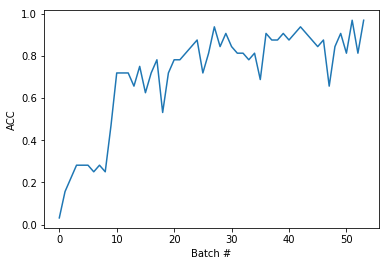

In [10]:
import matplotlib.pyplot as plt
plt.plot(acc_history)
plt.xlabel('Batch #')
plt.ylabel('ACC')
plt.show()

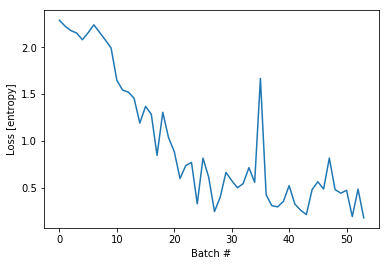

In [11]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()
#Text(0, 0.5, 'Loss [entropy]')

# Save Model

In [12]:
#remove top node
model.layers.pop()

In [13]:
tfe.Saver((model.variables)).save("./model/mnist.cpk")

'./model/mnist.cpk'